<a href="https://colab.research.google.com/github/mcbhavana27/ITS/blob/main/CNN_LSTM_depthwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
from keras.models import Sequential,Model
from keras.metrics import MeanSquaredError as mae
from keras.layers import LSTM,Dense,Dropout,Conv1D,TimeDistributed,Input,Flatten,Concatenate
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from math import sqrt
#from bokeh.plotting import figure,output_file, show
import datetime
from keras.callbacks import ModelCheckpoint
#from openpyxl import Workbook,load_workbook
from keras.layers import DepthwiseConv2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp  /content/drive/My\ Drive/DATA.zip /content/
!unzip DATA.zip

Archive:  DATA.zip
   creating: DATA/
   creating: DATA/402214/
  inflating: DATA/402214/8.csv       
  inflating: DATA/402214/9.csv       
  inflating: DATA/402214/1.csv       
  inflating: DATA/402214/2.csv       
  inflating: DATA/402214/5.csv       
  inflating: DATA/402214/4.csv       
  inflating: DATA/402214/11.csv      
  inflating: DATA/402214/3.csv       
  inflating: DATA/402214/10.csv      
  inflating: DATA/402214/12.csv      
  inflating: DATA/402214/13.csv      
  inflating: DATA/402214/7.csv       
  inflating: DATA/402214/6.csv       
   creating: DATA/402510/
  inflating: DATA/402510/3.csv       
  inflating: DATA/402510/12.csv      
  inflating: DATA/402510/13.csv      
  inflating: DATA/402510/10.csv      
  inflating: DATA/402510/8.csv       
  inflating: DATA/402510/4.csv       
  inflating: DATA/402510/11.csv      
  inflating: DATA/402510/7.csv       
  inflating: DATA/402510/6.csv       
  inflating: DATA/402510/9.csv       
  inflating: DATA/402510/5.csv      

In [ ]:
Data_file1= glob('DATA/402214'+'/*.csv')
Data_file2= glob('DATA/402510'+'/*.csv')
Data_file3= glob('DATA/402835'+'/*.csv')
Data_file4= glob('DATA/414025'+'/*.csv')

In [ ]:
def data(files,col):
    data=[]
    for file in files:
          data.append(pd.read_csv(file))
    full_data =pd.concat(data,ignore_index=True)
    cols=list(full_data)[col]
    data_set=full_data[cols].astype(str)
    data_set = np.array(data_set)
    return data_set

In [ ]:
Data1 = data(Data_file1,2)
Data2 = data(Data_file2,2)
Data3 = data(Data_file3,2)
Data4 = data(Data_file4,2)

In [ ]:
data1 = Data1.reshape(Data1.shape[0],1)
scaler1 =MinMaxScaler(feature_range=(0, 1))
data1_scaled = scaler1.fit_transform(data1)

In [ ]:
data_set = ([Data1,Data2,Data3,Data4])
max_len =max([len(data) for data in data_set ])

In [ ]:
def fill_data(data):
    x=data
    l=len(x)
    y=x
    while l<max_len:
        y= np.insert(x,-1,x[-1])
        x=y
        l=len(x)
    return y
        

In [ ]:
data1 =fill_data(Data1)
data2 = fill_data(Data2)
data3 = fill_data(Data3)
data4 = fill_data(Data4)
data_set = np.column_stack((data1,data2,data3,data4))

In [ ]:
scaler =MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_set)

In [ ]:
n_step = 21
Data =[]

for i in range(max_len-(n_step+1)):
    Data.append(data_scaled[i:i+n_step+1])

Data =np.array(Data)
#Data = Data.reshape(Data.shape[0],Data.shape[2],Data.shape[1])

In [ ]:
Train = Data[:]
Train_Y=Train[:,-1,0]
Train_X = Train[:,:n_step]
Train_X1 =Train[:,:n_step,0]
Train_wd =Train[:,:n_step]

In [ ]:
x=[]
x1=[]
x_w=[]
x_d=[]
y=[]
for i in range(len(Train)):
    if i >= 2016:
        x.append(Train_X[i])
        x_w.append(Train_X[i-2016])
        x_d.append(Train_X[i-288])
        x1.append(Train_X1[i])
        y.append(Train_Y[i])
x=np.array(x)
x1=np.array(x1)
x_w=np.array(x_w)
x_d=np.array(x_d)
y=np.array(y)      
y=y.reshape(y.shape[0],1)

In [ ]:
x1.shape,x.shape

((24155, 21), (24155, 21, 4))

In [ ]:
train_x=x[:-2016]
test_x=x[-2016:]
train_x1=x1[:-2016]
test_x1=x1[-2016:]
train_x_w=x_w[:-2016]
test_x_w=x_w[-2016:]
train_x_d=x_d[:-2016]
test_x_d=x_d[-2016:]
train_y=y[:-2016]
test_y=y[-2016:]


In [ ]:
train_x1=train_x1.reshape(train_x1.shape[0],train_x1.shape[1],1)
test_x1=test_x1.reshape(test_x1.shape[0],test_x1.shape[1],1)

In [ ]:
input1=Input(shape=(n_step,4),name ='input1')
input2=Input(shape=(n_step,1),name ='input2')
input3=Input(shape=(n_step,4),name ='input3')
input4=Input(shape=(n_step,4),name ='input4')

# Original 1D convolutional layer
# conv1d_layer1 = tf.keras.layers.Conv1D(filters=30, kernel_size=3, strides=1, padding='same', activation='relu')


# Original 1D convolutional layer
# conv1d_layer2 = tf.keras.layers.Conv1D(filters=30, kernel_size=3, strides=1, padding='same', activation='relu')

# Original 1D convolutional layer
# conv1d_layer3 = tf.keras.layers.Conv1D(filters=20, kernel_size=2, strides=1, padding='same', activation='relu')


con1=tf.keras.layers.DepthwiseConv1D(30,3,padding='same',activation='relu',name='con1')(input1)
# Depthwise separable version of the 1D convolutional layer
# depthwise_conv1d_layer1 = tf.keras.layers.DepthwiseConv1D(kernel_size=3, strides=1, padding='same', activation='relu')
# separable_conv1d_layer1 = tf.keras.layers.SeparableConv1D(filters=30, kernel_size=1, strides=1, padding='same', activation='relu')

con2=tf.keras.layers.DepthwiseConv1D(30,3,padding='same',activation='relu',name='con2')(con1)

# Depthwise separable version of the 1D convolutional layer
# depthwise_conv1d_layer2 = tf.keras.layers.DepthwiseConv1D(kernel_size=3, strides=1, padding='same', activation='relu')
# separable_conv1d_layer2 = tf.keras.layers.SeparableConv1D(filters=30, kernel_size=1, strides=1, padding='same', activation='relu')

con3=tf.keras.layers.DepthwiseConv1D(20,2,padding='same',activation='relu',name='con3')(con2)
# Depthwise separable version of the 1D convolutional layer
# depthwise_conv1d_layer3 = tf.keras.layers.DepthwiseConv1D(kernel_size=2, strides=1, padding='same', activation='relu')
# separable_conv1d_layer3 = tf.keras.layers.SeparableConv1D(filters=20, kernel_size=1, strides=1, padding='same', activation='relu')

con_fl = Flatten()(con3)

# # Stack the depthwise separable layers
# model = tf.keras.Sequential([
#   depthwise_conv1d_layer1,
#   separable_conv1d_layer1
# ])

lstm_out=LSTM(60,activation='relu',return_sequences=False,name='lstm_out')(input2)
lstm_out1=LSTM(30,activation='relu',return_sequences=True,name='lstm_out1')(input3)
lstm_out2=LSTM(30,activation='relu',return_sequences=False,name='lstm_out2')(lstm_out1)
lstm_out3=LSTM(30,activation='relu',return_sequences=True,name='lstm_out3')(input4)
lstm_out4=LSTM(30,activation='relu',return_sequences=False,name='lstm_out4')(lstm_out3)
x=Concatenate()([con_fl,lstm_out,lstm_out2,lstm_out4])
x1=Dense(20,activation='relu',name='x1')(x)
x2=Dense(10,activation='relu',name='x2')(x1)
output1 = Dense(1,activation='relu',kernel_regularizer=regularizers.l1(0.002),name='output1')(x2)
model=Model(inputs=[input1,input2,input3,input4],outputs=output1)
model.compile(optimizer='adam',loss='mse')

In [ ]:
history=model.fit([train_x,train_x1,train_x_w,train_x_d],train_y,epochs=100,validation_split=.15,verbose=1)

Epoch 1/100
589/589 [==============================] - 31s 43ms/step - loss: 0.4178 - val_loss: 0.4221
Epoch 2/100
589/589 [==============================] - 24s 41ms/step - loss: 0.0984 - val_loss: 0.0010
Epoch 3/100
589/589 [==============================] - 24s 41ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 4/100
589/589 [==============================] - 24s 41ms/step - loss: 8.1186e-04 - val_loss: 6.7102e-04
Epoch 5/100
589/589 [==============================] - 42s 72ms/step - loss: 7.1360e-04 - val_loss: 5.9846e-04
Epoch 6/100
589/589 [==============================] - 24s 41ms/step - loss: 6.6148e-04 - val_loss: 5.3074e-04
Epoch 7/100
589/589 [==============================] - 24s 41ms/step - loss: 5.8556e-04 - val_loss: 0.0013
Epoch 8/100
589/589 [==============================] - 25s 42ms/step - loss: 5.6512e-04 - val_loss: 4.3684e-04
Epoch 9/100
589/589 [==============================] - 25s 42ms/step - loss: 5.1248e-04 - val_loss: 4.5705e-04
Epoch 10/100
589/589 [=======

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 21, 4)]      0           []                               
                                                                                                  
 con1 (DepthwiseConv1D)         (None, 7, 4)         124         ['input1[0][0]']                 
                                                                                                  
 con2 (DepthwiseConv1D)         (None, 3, 4)         124         ['con1[0][0]']                   
                                                                                                  
 input3 (InputLayer)            [(None, 21, 4)]      0           []                               
                                                                                              

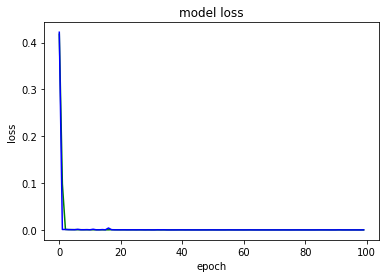

In [ ]:
plt.plot(history.history["loss"],color='green')
plt.plot(history.history["val_loss"],color='blue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
y_predict_scaled = model.predict([test_x,test_x1,test_x_w,test_x_d])

63/63 [==============================] - 1s 11ms/step


In [ ]:
y_predict=scaler1.inverse_transform(y_predict_scaled)

In [ ]:
test_Y=scaler1.inverse_transform(test_y)

In [ ]:
print(mae(y_predict,test_Y))

3.231132375815558


In [ ]:
print(sqrt(mse(y_predict,test_Y)))

4.391439123644025


In [ ]:
print(mape(y_predict,test_Y))

0.1044703642688132


In [ ]:
Error=[]
for i in range(len(test_Y)):
    Error.append(abs(y_predict[i]-test_Y[i]))

In [ ]:
# tf lite model with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]



# def representative_dataset_generator():
#   for value in X_test:
#     # Each scalar value must be inside of a 2D array that is wrapped in a list
#     print(value)
#     yield [np.array(value, dtype=np.float32, ndmin=2)]
# converter.representative_dataset = representative_dataset_generator
tflite_model = converter.convert()

# Save the model to disk
open("cnn_lstm_model_quantized.tflite", "wb").write(tflite_model)

92616

In [ ]:

tf_modelq = tf.lite.Interpreter('cnn_lstm_model_quantized.tflite')
tf_modelq.allocate_tensors()
input_details = tf_modelq.get_input_details()
output_details = tf_modelq.get_output_details()
tf_modelq_predictions = []
input_shape = input_details[0]['shape']
input_shape1 = input_details[1]['shape']
input_shape2 = input_details[2]['shape']
input_shape3 = input_details[3]['shape']
input_data = np.array(test_x, dtype=np.float32)
input_data1 = np.array(test_x1, dtype=np.float32)
input_data2 = np.array(test_x_w, dtype=np.float32)
input_data3 = np.array(test_x_d, dtype=np.float32)
tf_model_output_index = output_details[0]['index']
for i in range(len(test_x1)):
    tf_modelq.set_tensor(input_details[0]['index'], input_data2[i].reshape(1,input_data2.shape[1],input_data2.shape[2]))
    tf_modelq.set_tensor(input_details[1]['index'], input_data[i].reshape(1,input_data.shape[1],input_data.shape[2]))
    tf_modelq.set_tensor(input_details[2]['index'], input_data3[i].reshape(1,input_data3.shape[1],input_data3.shape[2]))
    tf_modelq.set_tensor(input_details[3]['index'], input_data1[i].reshape(1,input_data1.shape[1],input_data1.shape[2]))
    
    tf_modelq.invoke()
    x1=tf_modelq.get_tensor(tf_model_output_index)
    tf_modelq_predictions.append(x1[0])

In [ ]:
tf_pred=scaler1.inverse_transform(tf_modelq_predictions)

In [ ]:
print(mae(tf_pred,test_Y))

3.218364389430332


In [ ]:
print(sqrt(mse(tf_pred,test_Y)))

4.370306762181542


In [ ]:
print(mape(tf_pred,test_Y))

0.10468556565437277
